#project 2-2

In [1]:
import pandas as pd
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import activations
import seaborn as sns

%matplotlib inline

In [2]:
# for access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# load numerical and categorical dataset

In [3]:
dataset = pd.read_csv('/content/gdrive/MyDrive/Proj2_data/data2/desc.csv')
dataset.head()

,image_id,street,city,n_city,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [4]:
dataset.shape

(15474, 8)

## data cleaning

In [5]:
dataset.nunique()

image_id    15474
street      12401
city          415
n_city        415
bed            12
bath           32
sqft         3571
price        2320
dtype: int64

In [6]:
dataset.isnull().sum() # return number of missing values for each variable

image_id    0
street      0
city        0
n_city      0
bed         0
bath        0
sqft        0
price       0
dtype: int64

In [7]:
dataset.describe()

,image_id,n_city,bed,bath,sqft,price
count,15474.000000,15474.000000,15474.000000,15474.000000,15474.000000,1.547400e+04
mean,7736.500000,216.597518,3.506398,2.453251,2173.913209,7.031209e+05
std,4467.103368,112.372985,1.034838,0.958742,1025.339617,3.769762e+05
min,0.000000,0.000000,1.000000,0.000000,280.000000,1.950000e+05
25%,3868.250000,119.000000,3.000000,2.000000,1426.000000,4.450000e+05
50%,7736.500000,222.500000,3.000000,2.100000,1951.000000,6.390000e+05
75%,11604.750000,315.000000,4.000000,3.000000,2737.750000,8.349750e+05
max,15473.000000,414.000000,12.000000,36.000000,17667.000000,2.000000e+06


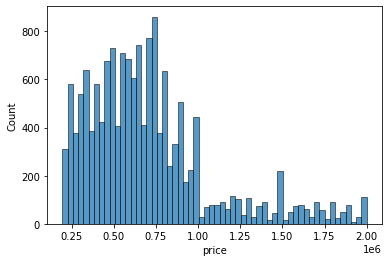

In [8]:
#histogram of price
sns.histplot(dataset['price'])

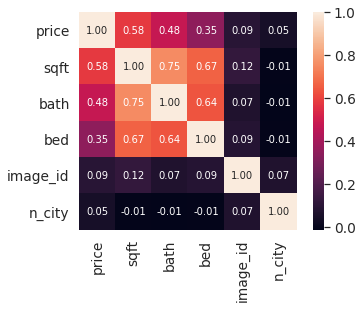

In [9]:
#price correlation matrix
correlation_matrix = dataset.corr()
k = 8 #number of variables for heatmap
cols = correlation_matrix.nlargest(k, 'price')['price'].index
cm = np.corrcoef(dataset[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

ماتریس وابستگی بالا نشان می دهد که مساحت خانه یشترین تاثیر را درقیمت خانه دارد و بعد از ان تعداد حمام بیشترین تاثیر را دارد. شماره شهر کمترین تاثیر را در قیمت خانه در این داده ها دارد.
در این داده شماره عکس تاثیری در قیمت خانه ندارد زیر برای هر خانه یک شماره عکس داریم  هیچ ربطی به قیمت ندارد. در مورد شماره شهر و نام شهر یکی باید انتخاب شود چون این دو مثل هم هستند و هر شهر یک شماره دارد پس ما شهر را انتخاب می کنیم.

In [10]:
dataset.drop(labels=['n_city', 'image_id'], axis=1, inplace=True) # remove irrelavent columns features
dataset.head()

,street,city,bed,bath,sqft,price
0,1317 Van Buren Avenue,"Salton City, CA",3,2.0,1560,201900
1,124 C Street W,"Brawley, CA",3,2.0,713,228500
2,2304 Clark Road,"Imperial, CA",3,1.0,800,273950
3,755 Brawley Avenue,"Brawley, CA",3,1.0,1082,350000
4,2207 R Carrillo Court,"Calexico, CA",4,3.0,2547,385100


داده هایی که از نوع عدد نیستند را به شکل قابل فهم برای شبکه در می آوریم و آن ها را کدگشایی می کنیم.

In [11]:
from sklearn.preprocessing import LabelEncoder
# encoding street variable

labelencoder_street = LabelEncoder()
dataset['street'] = labelencoder_street.fit_transform(dataset['street'])

In [12]:
# one hot encoder city variable (#415)
categorical_subset = dataset[['city']]
categorical_subset = pd.get_dummies(categorical_subset)
categorical_subset.head()

,"city_29 Palms, CA","city_Acton, CA","city_Adelanto, CA","city_Agoura Hills, CA","city_Agua Dulce, CA","city_Aguanga, CA","city_Alhambra, CA","city_Aliso Viejo, CA","city_Alpine, CA","city_Alta Loma, CA","city_Altadena, CA","city_Anaheim Hills, CA","city_Anaheim, CA","city_Angelus Oaks, CA","city_Anza, CA","city_Apple Valley, CA","city_Arcadia, CA","city_Arleta, CA","city_Arroyo Grande, CA","city_Artesia, CA","city_Arvin, CA","city_Atascadero, CA","city_Avila Beach, CA","city_Azusa, CA","city_Bakersfield, CA","city_Baldwin Park, CA","city_Banning, CA","city_Barstow, CA","city_Bear Valley Springs, CA","city_Beaumont, CA","city_Bell Gardens, CA","city_Bell, CA","city_Bellflower, CA","city_Belltown, CA","city_Bermuda Dunes, CA","city_Beverly Hills, CA","city_Big Bear City, CA","city_Big Bear Lake, CA","city_Big Bear, CA","city_Big River, CA",...,"city_Topanga, CA","city_Torrance, CA","city_Trabuco Canyon, CA","city_Tujunga, CA","city_Tustin, CA","city_Twin Peaks, CA","city_Upland, CA","city_Val Verde, CA","city_Valencia, CA","city_Valley Center, CA","city_Valley Glen, CA","city_Valley Village, CA","city_Van Nuys, CA","city_Vandenberg Village, CA","city_Venice, CA","city_Ventura, CA","city_Victorville, CA","city_View Park, CA","city_Villa Park, CA","city_Vista, CA","city_Walnut, CA","city_Warner Springs, CA","city_West Covina, CA","city_West Hills, CA","city_West Hollywood, CA","city_Westchester, CA","city_Westlake Village, CA","city_Westminster, CA","city_Whitewater, CA","city_Whittier, CA","city_Wildomar, CA","city_Wilmington, CA","city_Winchester, CA","city_Winnetka, CA","city_Wofford Heights, CA","city_Woodland Hills, CA","city_Wrightwood, CA","city_Yorba Linda, CA","city_Yucaipa, CA","city_Yucca Valley, CA"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
dataset.drop(labels=['city'], axis=1, inplace=True)
dataset = pd.concat([dataset, categorical_subset], axis = 1)
dataset.head()

,street,bed,bath,sqft,price,"city_29 Palms, CA","city_Acton, CA","city_Adelanto, CA","city_Agoura Hills, CA","city_Agua Dulce, CA","city_Aguanga, CA","city_Alhambra, CA","city_Aliso Viejo, CA","city_Alpine, CA","city_Alta Loma, CA","city_Altadena, CA","city_Anaheim Hills, CA","city_Anaheim, CA","city_Angelus Oaks, CA","city_Anza, CA","city_Apple Valley, CA","city_Arcadia, CA","city_Arleta, CA","city_Arroyo Grande, CA","city_Artesia, CA","city_Arvin, CA","city_Atascadero, CA","city_Avila Beach, CA","city_Azusa, CA","city_Bakersfield, CA","city_Baldwin Park, CA","city_Banning, CA","city_Barstow, CA","city_Bear Valley Springs, CA","city_Beaumont, CA","city_Bell Gardens, CA","city_Bell, CA","city_Bellflower, CA","city_Belltown, CA","city_Bermuda Dunes, CA",...,"city_Topanga, CA","city_Torrance, CA","city_Trabuco Canyon, CA","city_Tujunga, CA","city_Tustin, CA","city_Twin Peaks, CA","city_Upland, CA","city_Val Verde, CA","city_Valencia, CA","city_Valley Center, CA","city_Valley Glen, CA","city_Valley Village, CA","city_Van Nuys, CA","city_Vandenberg Village, CA","city_Venice, CA","city_Ventura, CA","city_Victorville, CA","city_View Park, CA","city_Villa Park, CA","city_Vista, CA","city_Walnut, CA","city_Warner Springs, CA","city_West Covina, CA","city_West Hills, CA","city_West Hollywood, CA","city_Westchester, CA","city_Westlake Village, CA","city_Westminster, CA","city_Whitewater, CA","city_Whittier, CA","city_Wildomar, CA","city_Wilmington, CA","city_Winchester, CA","city_Winnetka, CA","city_Wofford Heights, CA","city_Woodland Hills, CA","city_Wrightwood, CA","city_Yorba Linda, CA","city_Yucaipa, CA","city_Yucca Valley, CA"
0,1552,3,2.0,1560,201900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1184,3,2.0,713,228500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4565,3,1.0,800,273950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10920,3,1.0,1082,350000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4346,4,3.0,2547,385100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


در اینجا قسمت اعشاری حمام را جدا می کنیم و به عنوان تعداد نیم حمام در نظر میگیریم.

In [14]:
# spliting full bath and half bath
dataset['fullbath'] = dataset.apply(lambda x: int(str(x['bath']).split('.')[0]), axis = 1)
dataset['halfbath'] = dataset.apply(lambda x: int(str(x['bath']).split('.')[1]), axis = 1)
dataset = dataset.drop(['bath'], axis=1)

In [15]:
dataset.head()

,street,bed,sqft,price,"city_29 Palms, CA","city_Acton, CA","city_Adelanto, CA","city_Agoura Hills, CA","city_Agua Dulce, CA","city_Aguanga, CA","city_Alhambra, CA","city_Aliso Viejo, CA","city_Alpine, CA","city_Alta Loma, CA","city_Altadena, CA","city_Anaheim Hills, CA","city_Anaheim, CA","city_Angelus Oaks, CA","city_Anza, CA","city_Apple Valley, CA","city_Arcadia, CA","city_Arleta, CA","city_Arroyo Grande, CA","city_Artesia, CA","city_Arvin, CA","city_Atascadero, CA","city_Avila Beach, CA","city_Azusa, CA","city_Bakersfield, CA","city_Baldwin Park, CA","city_Banning, CA","city_Barstow, CA","city_Bear Valley Springs, CA","city_Beaumont, CA","city_Bell Gardens, CA","city_Bell, CA","city_Bellflower, CA","city_Belltown, CA","city_Bermuda Dunes, CA","city_Beverly Hills, CA",...,"city_Trabuco Canyon, CA","city_Tujunga, CA","city_Tustin, CA","city_Twin Peaks, CA","city_Upland, CA","city_Val Verde, CA","city_Valencia, CA","city_Valley Center, CA","city_Valley Glen, CA","city_Valley Village, CA","city_Van Nuys, CA","city_Vandenberg Village, CA","city_Venice, CA","city_Ventura, CA","city_Victorville, CA","city_View Park, CA","city_Villa Park, CA","city_Vista, CA","city_Walnut, CA","city_Warner Springs, CA","city_West Covina, CA","city_West Hills, CA","city_West Hollywood, CA","city_Westchester, CA","city_Westlake Village, CA","city_Westminster, CA","city_Whitewater, CA","city_Whittier, CA","city_Wildomar, CA","city_Wilmington, CA","city_Winchester, CA","city_Winnetka, CA","city_Wofford Heights, CA","city_Woodland Hills, CA","city_Wrightwood, CA","city_Yorba Linda, CA","city_Yucaipa, CA","city_Yucca Valley, CA",fullbath,halfbath
0,1552,3,1560,201900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
1,1184,3,713,228500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
2,4565,3,800,273950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,10920,3,1082,350000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4346,4,2547,385100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0


In [16]:
features = dataset.drop(columns='price')
targets = pd.DataFrame(dataset['price'])
features.shape
type(features)

pandas.core.frame.DataFrame

# load image data

In [ ]:
# import zipfile
# # unzip image file
# local_zip = '/content/gdrive/MyDrive/Proj2_data/data2/pics.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/gdrive/MyDrive/house_pics1')
# zip_ref.close()

چک کردن تعداد عناصر موجود در فایل آنزیپ شده عکس برای اطمینان از لود شدن درست عکسها

In [17]:
import os
print(len(os.listdir('/content/gdrive/MyDrive/house_pics1/pics'))) # number of pictures in pics

15474


In [18]:
# load all images in a directory
from os import listdir
from matplotlib import image

loaded_images = []
j = 0
for i in range(j*2579 ,2579*(j +1)):
	# load image
  img_data = image.imread('/content/gdrive/MyDrive/house_pics1/pics/' + str(i) +'.jpg')
	# store loaded image
  loaded_images.append(img_data)
  print('> loaded %s %s' % (i, img_data.shape))
 

> loaded 0 (350, 350, 3)
> loaded 1 (311, 415, 3)
> loaded 2 (311, 415, 3)
> loaded 3 (311, 415, 3)
> loaded 4 (311, 415, 3)
> loaded 5 (311, 415, 3)
> loaded 6 (311, 415, 3)
> loaded 7 (311, 415, 3)
> loaded 8 (311, 415, 3)
> loaded 9 (311, 415, 3)
> loaded 10 (311, 415, 3)
> loaded 11 (311, 415, 3)
> loaded 12 (311, 415, 3)
> loaded 13 (311, 415, 3)
> loaded 14 (350, 525, 4)
> loaded 15 (311, 415, 3)
> loaded 16 (311, 415, 3)
> loaded 17 (311, 415, 3)
> loaded 18 (311, 415, 3)
> loaded 19 (311, 415, 3)
> loaded 20 (311, 415, 3)
> loaded 21 (311, 415, 3)
> loaded 22 (311, 415, 3)
> loaded 23 (311, 415, 3)
> loaded 24 (311, 415, 3)
> loaded 25 (311, 415, 3)
> loaded 26 (311, 415, 3)
> loaded 27 (311, 415, 3)
> loaded 28 (311, 415, 3)
> loaded 29 (311, 415, 3)
> loaded 30 (311, 415, 3)
> loaded 31 (311, 415, 3)
> loaded 32 (311, 415, 3)
> loaded 33 (311, 415, 3)
> loaded 34 (311, 415, 3)
> loaded 35 (311, 415, 3)
> loaded 36 (311, 415, 3)
> loaded 37 (311, 415, 3)
> loaded 38 (311, 415,

In [19]:
len(loaded_images)

2579

In [20]:
loaded_images1 = []
j = 1
for i in range(j*2579 ,2579*(j +1)):
	# load image
  img_data = image.imread('/content/gdrive/MyDrive/house_pics1/pics/' + str(i) +'.jpg')
	# store loaded image
  loaded_images.append(img_data)
  print('> loaded %s %s' % (i, img_data.shape))

> loaded 2579 (311, 415, 3)
> loaded 2580 (311, 415, 3)
> loaded 2581 (311, 415, 3)
> loaded 2582 (311, 415, 3)
> loaded 2583 (311, 415, 3)
> loaded 2584 (311, 415, 3)
> loaded 2585 (311, 415, 3)
> loaded 2586 (311, 415, 3)
> loaded 2587 (311, 415, 3)
> loaded 2588 (311, 415, 3)
> loaded 2589 (311, 415, 3)
> loaded 2590 (311, 415, 3)
> loaded 2591 (311, 415, 3)
> loaded 2592 (311, 415, 3)
> loaded 2593 (311, 415, 3)
> loaded 2594 (311, 415, 3)
> loaded 2595 (311, 415, 3)
> loaded 2596 (311, 415, 3)
> loaded 2597 (311, 415, 3)
> loaded 2598 (311, 415, 3)
> loaded 2599 (311, 415, 3)
> loaded 2600 (311, 415, 4)
> loaded 2601 (311, 415, 3)
> loaded 2602 (311, 415, 3)
> loaded 2603 (311, 415, 3)
> loaded 2604 (311, 415, 3)
> loaded 2605 (311, 415, 3)
> loaded 2606 (311, 415, 3)
> loaded 2607 (311, 415, 3)
> loaded 2608 (311, 415, 3)
> loaded 2609 (311, 415, 3)
> loaded 2610 (311, 415, 3)
> loaded 2611 (311, 415, 3)
> loaded 2612 (311, 415, 3)
> loaded 2613 (311, 415, 3)
> loaded 2614 (311, 

In [21]:
for i in loaded_images1:
  loaded_images.append(i)

In [22]:
loaded_images1 = []
j = 2
for i in range(j*2579 ,2579*(j +1)):
	# load image
  img_data = image.imread('/content/gdrive/MyDrive/house_pics1/pics/' + str(i) +'.jpg')
	# store loaded image
  loaded_images.append(img_data)
  print('> loaded %s %s' % (i, img_data.shape))

> loaded 5158 (311, 415, 3)
> loaded 5159 (311, 415, 3)
> loaded 5160 (311, 415, 3)
> loaded 5161 (311, 415, 3)
> loaded 5162 (311, 415, 3)
> loaded 5163 (311, 415, 3)
> loaded 5164 (311, 415, 3)
> loaded 5165 (311, 415, 3)
> loaded 5166 (311, 415, 3)
> loaded 5167 (311, 415, 3)
> loaded 5168 (311, 415, 3)
> loaded 5169 (311, 415, 3)
> loaded 5170 (311, 415, 3)
> loaded 5171 (311, 415, 3)
> loaded 5172 (311, 415, 3)
> loaded 5173 (311, 415, 3)
> loaded 5174 (311, 415, 3)
> loaded 5175 (311, 415, 3)
> loaded 5176 (311, 415, 3)
> loaded 5177 (350, 350, 3)
> loaded 5178 (311, 415, 3)
> loaded 5179 (311, 415, 3)
> loaded 5180 (350, 350, 3)
> loaded 5181 (311, 415, 3)
> loaded 5182 (311, 415, 3)
> loaded 5183 (311, 415, 3)
> loaded 5184 (311, 415, 3)
> loaded 5185 (311, 415, 3)
> loaded 5186 (311, 415, 3)
> loaded 5187 (311, 415, 3)
> loaded 5188 (311, 415, 3)
> loaded 5189 (311, 415, 3)
> loaded 5190 (311, 415, 3)
> loaded 5191 (311, 415, 3)
> loaded 5192 (311, 415, 3)
> loaded 5193 (311, 

In [23]:
for i in loaded_images1:
  loaded_images.append(i)

In [24]:
loaded_images1 = []
j = 3
for i in range(j*2579 ,2579*(j +1)):
	# load image
  img_data = image.imread('/content/gdrive/MyDrive/house_pics1/pics/' + str(i) +'.jpg')
	# store loaded image
  loaded_images.append(img_data)
  print('> loaded %s %s' % (i, img_data.shape))

> loaded 7737 (311, 415, 3)
> loaded 7738 (311, 415, 3)
> loaded 7739 (311, 415, 3)
> loaded 7740 (311, 415, 3)
> loaded 7741 (311, 415, 3)
> loaded 7742 (311, 415, 3)
> loaded 7743 (350, 350, 3)
> loaded 7744 (311, 415, 3)
> loaded 7745 (311, 415, 3)
> loaded 7746 (311, 415, 3)
> loaded 7747 (311, 415, 3)
> loaded 7748 (311, 415, 3)
> loaded 7749 (311, 415, 3)
> loaded 7750 (311, 415, 3)
> loaded 7751 (350, 350, 3)
> loaded 7752 (311, 415, 3)
> loaded 7753 (311, 415, 3)
> loaded 7754 (311, 415, 3)
> loaded 7755 (311, 415, 3)
> loaded 7756 (311, 415, 3)
> loaded 7757 (311, 415, 3)
> loaded 7758 (311, 415, 3)
> loaded 7759 (311, 415, 3)
> loaded 7760 (311, 415, 3)
> loaded 7761 (311, 415, 3)
> loaded 7762 (311, 415, 3)
> loaded 7763 (311, 415, 3)
> loaded 7764 (311, 415, 3)
> loaded 7765 (311, 415, 3)
> loaded 7766 (311, 415, 3)
> loaded 7767 (311, 415, 3)
> loaded 7768 (311, 415, 3)
> loaded 7769 (311, 415, 3)
> loaded 7770 (311, 415, 3)
> loaded 7771 (311, 415, 3)
> loaded 7772 (311, 

In [25]:
for i in loaded_images1:
  loaded_images.append(i)

In [26]:
loaded_images1 = []
j = 4
for i in range(j*2579 ,2579*(j +1)):
	# load image
  img_data = image.imread('/content/gdrive/MyDrive/house_pics1/pics/' + str(i) +'.jpg')
	# store loaded image
  loaded_images.append(img_data)
  print('> loaded %s %s' % (i, img_data.shape))

> loaded 10316 (311, 415, 3)
> loaded 10317 (311, 415, 3)
> loaded 10318 (311, 415, 3)
> loaded 10319 (311, 415, 3)
> loaded 10320 (311, 415, 3)
> loaded 10321 (311, 415, 3)
> loaded 10322 (311, 415, 3)
> loaded 10323 (311, 415, 3)
> loaded 10324 (311, 415, 3)
> loaded 10325 (311, 415, 3)
> loaded 10326 (311, 415, 3)
> loaded 10327 (311, 415, 3)
> loaded 10328 (311, 415, 3)
> loaded 10329 (311, 415, 3)
> loaded 10330 (311, 415, 3)
> loaded 10331 (311, 415, 3)
> loaded 10332 (311, 415, 3)
> loaded 10333 (311, 415, 3)
> loaded 10334 (311, 415, 3)
> loaded 10335 (311, 415, 3)
> loaded 10336 (311, 415, 3)
> loaded 10337 (311, 415, 3)
> loaded 10338 (311, 415, 3)
> loaded 10339 (311, 415, 3)
> loaded 10340 (311, 415, 3)
> loaded 10341 (311, 415, 3)
> loaded 10342 (311, 415, 3)
> loaded 10343 (311, 415, 3)
> loaded 10344 (311, 415, 3)
> loaded 10345 (311, 415, 3)
> loaded 10346 (311, 415, 3)
> loaded 10347 (311, 415, 3)
> loaded 10348 (311, 415, 3)
> loaded 10349 (311, 415, 3)
> loaded 10350

In [27]:
for i in loaded_images1:
  loaded_images.append(i)

In [28]:
loaded_images1 = []
j = 5
for i in range(j*2579 ,2579*(j +1)):
	# load image
  img_data = image.imread('/content/gdrive/MyDrive/house_pics1/pics/' + str(i) +'.jpg')
	# store loaded image
  loaded_images.append(img_data)
  print('> loaded %s %s' % (i, img_data.shape))

> loaded 12895 (311, 415, 3)
> loaded 12896 (311, 415, 3)
> loaded 12897 (311, 415, 3)
> loaded 12898 (311, 415, 3)
> loaded 12899 (311, 415, 3)
> loaded 12900 (311, 415, 3)
> loaded 12901 (311, 415, 3)
> loaded 12902 (311, 415, 3)
> loaded 12903 (311, 415, 3)
> loaded 12904 (311, 415, 3)
> loaded 12905 (311, 415, 3)
> loaded 12906 (311, 415, 3)
> loaded 12907 (311, 415, 3)
> loaded 12908 (311, 415, 3)
> loaded 12909 (311, 415, 3)
> loaded 12910 (311, 415, 3)
> loaded 12911 (311, 415, 3)
> loaded 12912 (311, 415, 3)
> loaded 12913 (311, 415, 3)
> loaded 12914 (311, 415, 3)
> loaded 12915 (311, 415, 3)
> loaded 12916 (311, 415, 3)
> loaded 12917 (311, 415, 3)
> loaded 12918 (311, 415, 3)
> loaded 12919 (311, 415, 3)
> loaded 12920 (311, 415, 3)
> loaded 12921 (311, 415, 3)
> loaded 12922 (311, 415, 3)
> loaded 12923 (311, 415, 3)
> loaded 12924 (311, 415, 3)
> loaded 12925 (311, 415, 3)
> loaded 12926 (311, 415, 3)
> loaded 12927 (311, 415, 3)
> loaded 12928 (311, 415, 3)
> loaded 12929

In [29]:
for i in loaded_images1:
  loaded_images.append(i)

In [30]:
print(len(loaded_images))

15474


طبق نتیجه زیر میبینم که داده های عکسی ما سایز یکسانی ندارند بنابراین بهتر است سایز همه را یکسان کنیم

In [31]:
# image_dataset : an array of image pixels
# imag_id starts from 0

image_dataset = np.array(loaded_images)
print(image_dataset[8].shape)
print(image_dataset[0].shape)


(311, 415, 3)
(350, 350, 3)


In [32]:
image_dataset.shape

(15474,)

همانطور که می بینیم یکسری از عکس های 4 کاناله در داده های ما موجود هستند که اید اینها را به همراه داده هایشان در جدول حذف کنیم.

In [33]:
print(image_dataset[14].shape)

(350, 525, 4)


یک عکس را برای مثال چاپ می کنیم، که همان عکس شماره 14 است که چار کاناله بود، همانطور که میبینم عکس مربوط به این خانه هنوز لود نشده است.

<function matplotlib.pyplot.show>

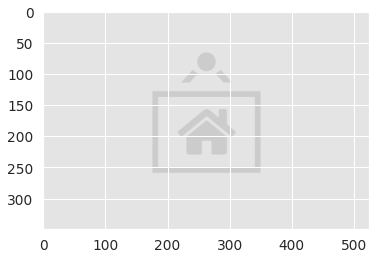

In [34]:
plt.imshow(image_dataset[14])
plt.show

# data preprocessing

با استفاده از کد زیر تمامی عکس هایی را که ناقص هستند را شناسایی می کنیم تا بتوانی از داده هایمان پاک کنیم

In [35]:
four_channel_data = []
for i in range(len(image_dataset)):
  if image_dataset[i].shape[2] == 4:
    four_channel_data.append(i)

قطعه کد زیر نشان می دهند 11 عکس ناقص داریم که باید پاک شوند

In [36]:
print(len(four_channel_data))
print(four_channel_data)

11
[14, 2600, 3747, 4754, 5524, 5728, 8886, 9081, 9194, 10000, 12498]


فایل نام پای را ذخیره می کنیم

In [ ]:
# save numpy array as npz file
from numpy import savez_compressed
# define data
# save to npy file
savez_compressed('image_dataset.npz', image_dataset)

In [ ]:
با استفاده از قطعه کد زیر سطرهای مریوط به عکس های ناقص را از دادهایمان پاک می کنیم

In [37]:
# pandas drop rows
features = features.drop([14, 2600, 3747, 4754, 5524, 5728, 8886, 9081, 9194, 10000, 12498], axis=0)
targets = targets.drop([14, 2600, 3747, 4754, 5524, 5728, 8886, 9081, 9194, 10000, 12498], axis=0)

In [38]:
targets.shape

(15463, 1)

با استفاده از کد زیر عکس های ناقص را از دادهای مربوط به عکس هایمان پاک می کنیم

In [40]:
image_dataset = np.delete(image_dataset,[14, 2600, 3747, 4754, 5524, 5728, 8886, 9081, 9194, 10000, 12498])

In [41]:
image_dataset.shape

(15463,)

چجوری همه رو یه سایز کنم یه طوری که کیفیت عکسا بهم نخوره؟؟؟؟؟

In [42]:
min_shape0 = 1000
min_shape1 = 1000
for i in range(15463):
  if image_dataset[i].shape[0] <= min_shape0:
    min_shape0 = image_dataset[i].shape[0]
  if image_dataset[i].shape[1] <= min_shape1:
    min_shape1 = image_dataset[i].shape[1]


In [43]:
print(min_shape0, min_shape1)

311 350


<function matplotlib.pyplot.show>

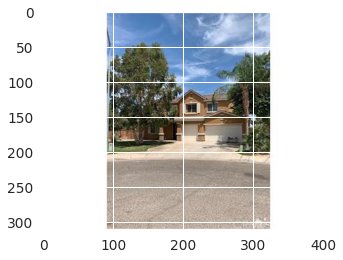

In [44]:
plt.imshow(image_dataset[8])
plt.show


In [45]:
import cv2
# resize all images to 32x32
for i in range(image_dataset.shape[0]):
  image_dataset[i] = cv2.resize(image_dataset[i],(100,100))

print(image_dataset[8].shape)
print(image_dataset[0].shape)


(100, 100, 3)
(100, 100, 3)


با تغییر سایز می بینیم که عکس پایین نسبت به عکس بالا که در سایز اصلی خودش بوده ستونش کوچکتر شده است

<function matplotlib.pyplot.show>

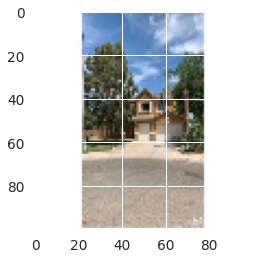

In [46]:
plt.imshow(image_dataset[8])
plt.show

In [53]:
img_dataset = []
for i in image_dataset:
  img_dataset.append(i)

In [54]:
img_dataset = np.array(img_dataset)

In [55]:
img_dataset.shape

(15463, 100, 100, 3)

با استفاده کد زیر داده های مربوط به ورودی های متنی و عددی و داده های عکس و 

---

خروجی ها را به دو بخش تست و آموزشی تقسیم می کنیم. 20 درصد داده ها را به عنوان 

---

داده ی تست در نظر می گیریم 

In [56]:
from sklearn.model_selection import train_test_split
(X_train, X_test, X_imgtrain, X_imgtest, y_train, y_test) = train_test_split(features,img_dataset ,targets, test_size=0.2, random_state=42, shuffle=False)

In [57]:
print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)
print("X_imgtrain : ", X_imgtrain.shape)
print("y_train : ",y_train.shape)
print("type of X_train : ",type(X_train))

X_train :  (12370, 420)
X_test :  (3093, 420)
X_imgtrain :  (12370, 100, 100, 3)
y_train :  (12370, 1)
type of X_train :  <class 'pandas.core.frame.DataFrame'>


In [58]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

نرمال سازی داده ها در این بخش انجام میشود

In [59]:
# data preprocessing
# scale data to the range of [0, 1]
from sklearn.preprocessing import StandardScaler
X_imgtrain = X_imgtrain.astype("float32") # چرا؟؟؟؟؟؟؟؟؟؟؟؟؟؟؟؟
X_imgtrain = X_imgtrain / 255.0

X_imgtest = X_imgtest.astype("float32")
X_imgtest = X_imgtest / 255.0

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from skimage import exposure
# produce function for adaptive histogram equalization 
def HE(img): 
    img_eq = exposure.equalize_hist(img)
    return img_eq

In [66]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_loss',verbose=1, save_best_only=True)

# model 1

In [ ]:
# input_model1 = Input((X_imgtrain.shape[1],X_imgtrain.shape[2],X_imgtrain.shape[3]),name = 'input1_layer')
# input_model2 = Input((X_train.shape[1]),name = 'input2_layer')

# #######################################################
# #model1 CNN
# model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
# model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
# model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv1_2_5')(model1)
# model1 = BatchNormalization(name = 'Bnorm1_2')(model1)
# model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
# model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv1_3_3')(model1)
# model1 = BatchNormalization(name = 'Bnorm1_3')(model1)
# model1 = Conv2D(64,(3,3), activation='relu' ,padding='valid',name = 'Conv1_4_3')(model1)
# model1 = BatchNormalization(name = 'Bnorm1_4')(model1)
# model1 = AveragePooling2D((2, 2),name = 'AvgPool1_1')(model1)
# model1 = Conv2D(128,(1,1), activation='relu' ,padding='valid',name = 'Conv1_5_1')(model1)
# model1 = BatchNormalization(name = 'Bnorm1_5')(model1)
# model1 = MaxPooling2D((2, 2),name = 'MaxPool1_2')(model1)
# model1 = Flatten(name = 'Flatten1')(model1)
# #######################################################
# #model2 nn
# model2 = Dense(units = 64, activation = 'relu')(input_model2)
# model2 = Dropout(rate = 0.2)(model2)
# model2 = Dense(units = 32, activation = 'relu')(model2)
# model2 = Dense(units = 8, activation = 'relu')(model2)
# #######################################################
# merged = Concatenate()([model1, model2])
# # neural network 
# merged = Dense(units = 64, activation = 'relu')(merged)
# merged = Dropout(rate = 0.2)(merged)
# merged = BatchNormalization()(merged)
# merged = Dense(units = 20, activation = 'relu')(merged)
# merged = BatchNormalization()(merged)
# merged = Dense(units = 15, activation = 'relu')(merged)
# merged = BatchNormalization()(merged)
# output = Dense(units = 1, activation = 'linear')(merged)

# model = Model(inputs= [input_model1,input_model2], outputs=[output])
# model.summary()

In [ ]:
# plot_model(model, show_shapes=True)

In [ ]:
# sgd = SGD(lr=0.01, momentum=0.9)
# model.compile(optimizer=sgd, loss='mse')

In [ ]:
# history = model.fit(x = [X_imgtrain, X_train], y = y_train ,batch_size = 128 ,epochs= 5,validation_data=[X_imgtest, X_test],verbose=1,callbacks=[checkpointer])

In [ ]:
# model.save_weights("model1_weights_hist.h5")
# model.save("model1_hist.h5")

In [ ]:
# val_loss = history.history['val_loss']
# loss = history.history['loss']

# plt.plot(val_loss)
# plt.plot(loss)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(['Val error','Train error'], loc='upper right')
# plt.savefig('plot_error.png')
# plt.show()

##model1

In [96]:
input_model1 = Input((X_imgtrain.shape[1],X_imgtrain.shape[2],X_imgtrain.shape[3]),name = 'input1_layer')
input_model2 = Input((X_train.shape[1]),name = 'input2_layer')

#######################################################
#model1 CNN
model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv1_2_5')(model1)
model1 = BatchNormalization(name = 'Bnorm1_2')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv1_3_3')(model1)
model1 = BatchNormalization(name = 'Bnorm1_3')(model1)
model1 = AveragePooling2D((2, 2),name = 'AvgPool1_1')(model1)
model1 = Flatten(name = 'Flatten1')(model1)
#######################################################
#model2 nn
model2 = Dense(units = 64, activation = 'relu')(input_model2)
model2 = Dropout(rate = 0.2)(model2)
model2 = Dense(units = 32, activation = 'relu')(model2)
model2 = Dense(units = 8, activation = 'relu')(model2)
#######################################################
merged = Concatenate()([model1, model2])
# neural network 
merged = Dense(units = 64, activation = 'relu')(merged)
merged = Dropout(rate = 0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(units = 20, activation = 'relu')(merged)
merged = BatchNormalization()(merged)
output = Dense(units = 1, activation = 'linear')(merged)

model = Model(inputs= [input_model1,input_model2], outputs=[output])
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1_layer (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1_5 (Conv2D)              (None, 96, 96, 32)   2432        input1_layer[0][0]               
__________________________________________________________________________________________________
Bnorm1_1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1_1_5[0][0]                  
__________________________________________________________________________________________________
Conv1_2_5 (Conv2D)              (None, 96, 96, 32)   25632       Bnorm1_1[0][0]                   
______________________________________________________________________________________

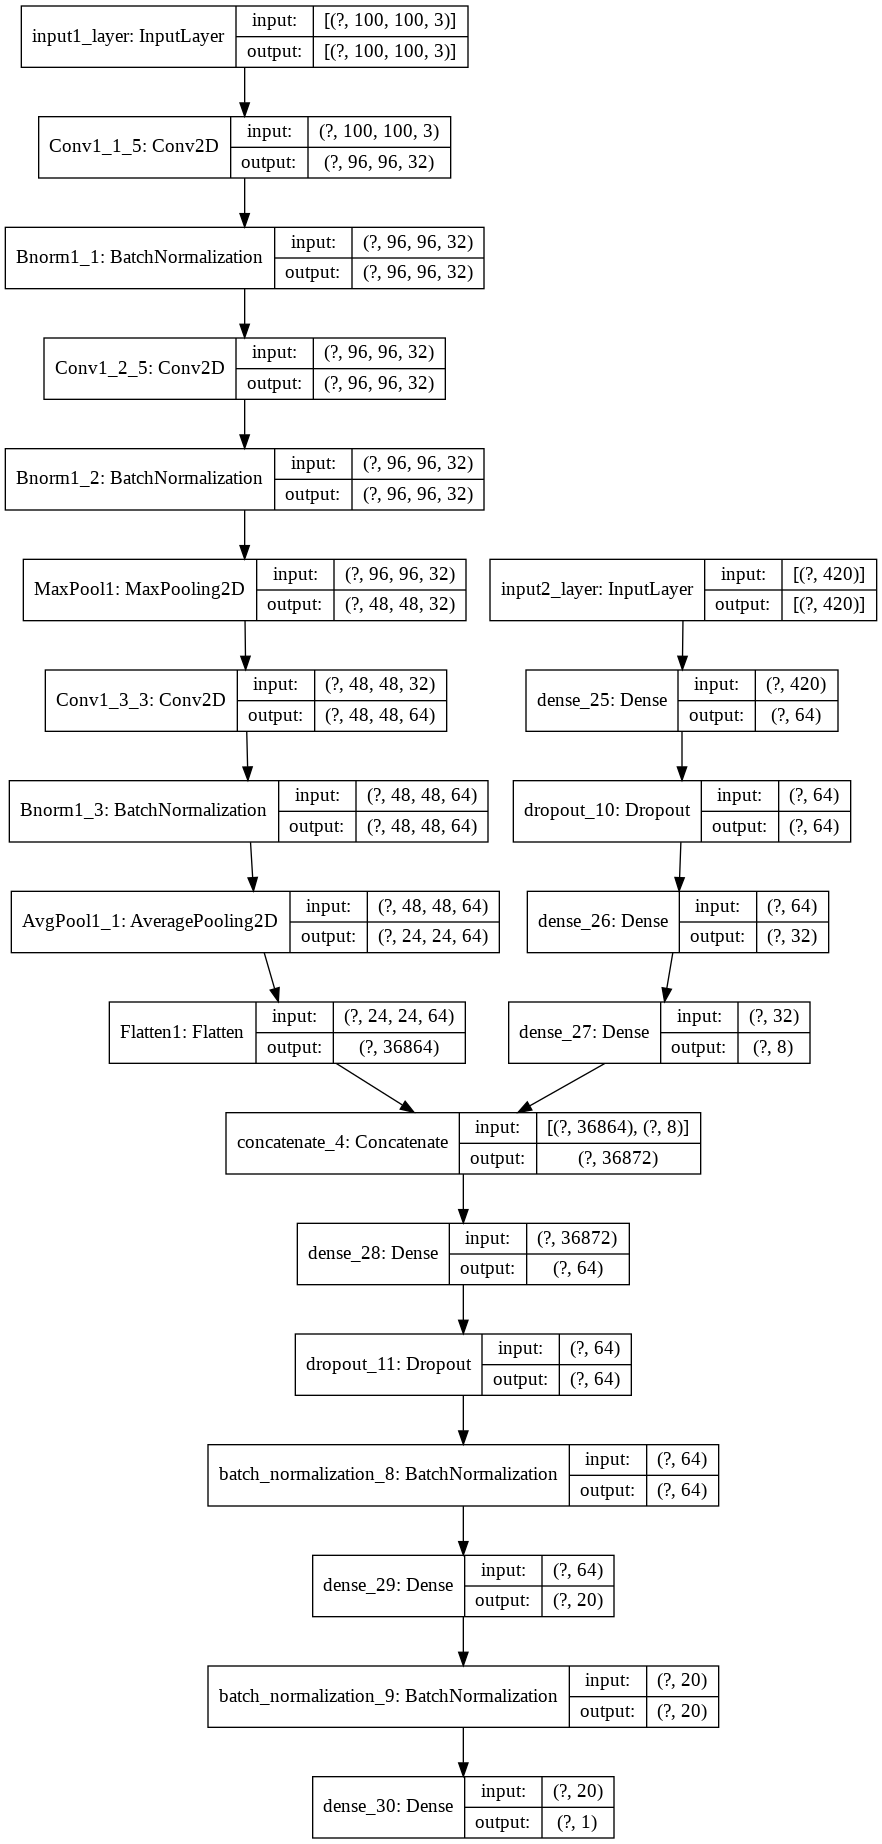

In [97]:
plot_model(model, show_shapes=True)

In [98]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer=adam, loss='mse')

In [99]:
history = model.fit(x = [X_imgtrain, X_train], y = y_train ,batch_size = 128 ,epochs= 5,validation_data=([X_imgtest, X_test],y_test),verbose=1,callbacks=[checkpointer])

Epoch 1/5
97/97 [==============================] - ETA: 0s - loss: 601424330752.0000
Epoch 00001: val_loss did not improve from 0.00000
97/97 [==============================] - 10s 99ms/step - loss: 601424330752.0000 - val_loss: 776564506624.0000
Epoch 2/5
97/97 [==============================] - ETA: 0s - loss: 601418825728.0000
Epoch 00002: val_loss did not improve from 0.00000
97/97 [==============================] - 9s 97ms/step - loss: 601418825728.0000 - val_loss: 776543535104.0000
Epoch 3/5
97/97 [==============================] - ETA: 0s - loss: 601411747840.0000
Epoch 00003: val_loss did not improve from 0.00000
97/97 [==============================] - 9s 96ms/step - loss: 601411747840.0000 - val_loss: 776551727104.0000
Epoch 4/5
97/97 [==============================] - ETA: 0s - loss: 601403621376.0000
Epoch 00004: val_loss did not improve from 0.00000
97/97 [==============================] - 9s 95ms/step - loss: 601403621376.0000 - val_loss: 776535801856.0000
Epoch 5/5
97/97

In [100]:
model.save_weights("model1_weights.h5")
model.save("model1.h5")

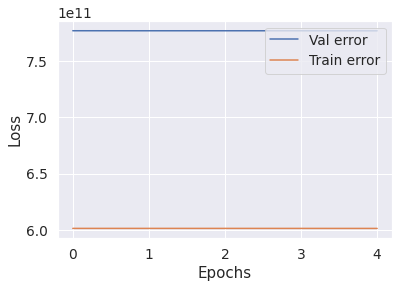

In [101]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

vanish gradient
بنظر می رشد مدل ما ونیش شده که تابع لاس تغییر نمی کند تعداد لایه ها را کمتر می کنیم

##model2

In [102]:
input_model1 = Input((X_imgtrain.shape[1],X_imgtrain.shape[2],X_imgtrain.shape[3]),name = 'input1_layer')
input_model2 = Input((X_train.shape[1]),name = 'input2_layer')

#######################################################
#model1 CNN
model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv1_3_3')(model1)
model1 = BatchNormalization(name = 'Bnorm1_3')(model1)
model1 = AveragePooling2D((2, 2),name = 'AvgPool1_1')(model1)
model1 = Flatten(name = 'Flatten1')(model1)
#######################################################
#model2 nn
model2 = Dense(units = 50, activation = 'relu')(input_model2)
model2 = Dropout(rate = 0.2)(model2)
model2 = Dense(units = 32, activation = 'relu')(model2)
model2 = Dense(units = 8, activation = 'relu')(model2)
#######################################################
merged = Concatenate()([model1, model2])
# neural network 
merged = Dense(units = 50, activation = 'relu')(merged)
merged = Dropout(rate = 0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(units = 20, activation = 'relu')(merged)
merged = BatchNormalization()(merged)
output = Dense(units = 1, activation = 'linear')(merged)

model = Model(inputs= [input_model1,input_model2], outputs=[output])
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1_layer (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1_5 (Conv2D)              (None, 96, 96, 32)   2432        input1_layer[0][0]               
__________________________________________________________________________________________________
Bnorm1_1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1_1_5[0][0]                  
__________________________________________________________________________________________________
MaxPool1 (MaxPooling2D)         (None, 48, 48, 32)   0           Bnorm1_1[0][0]                   
______________________________________________________________________________________

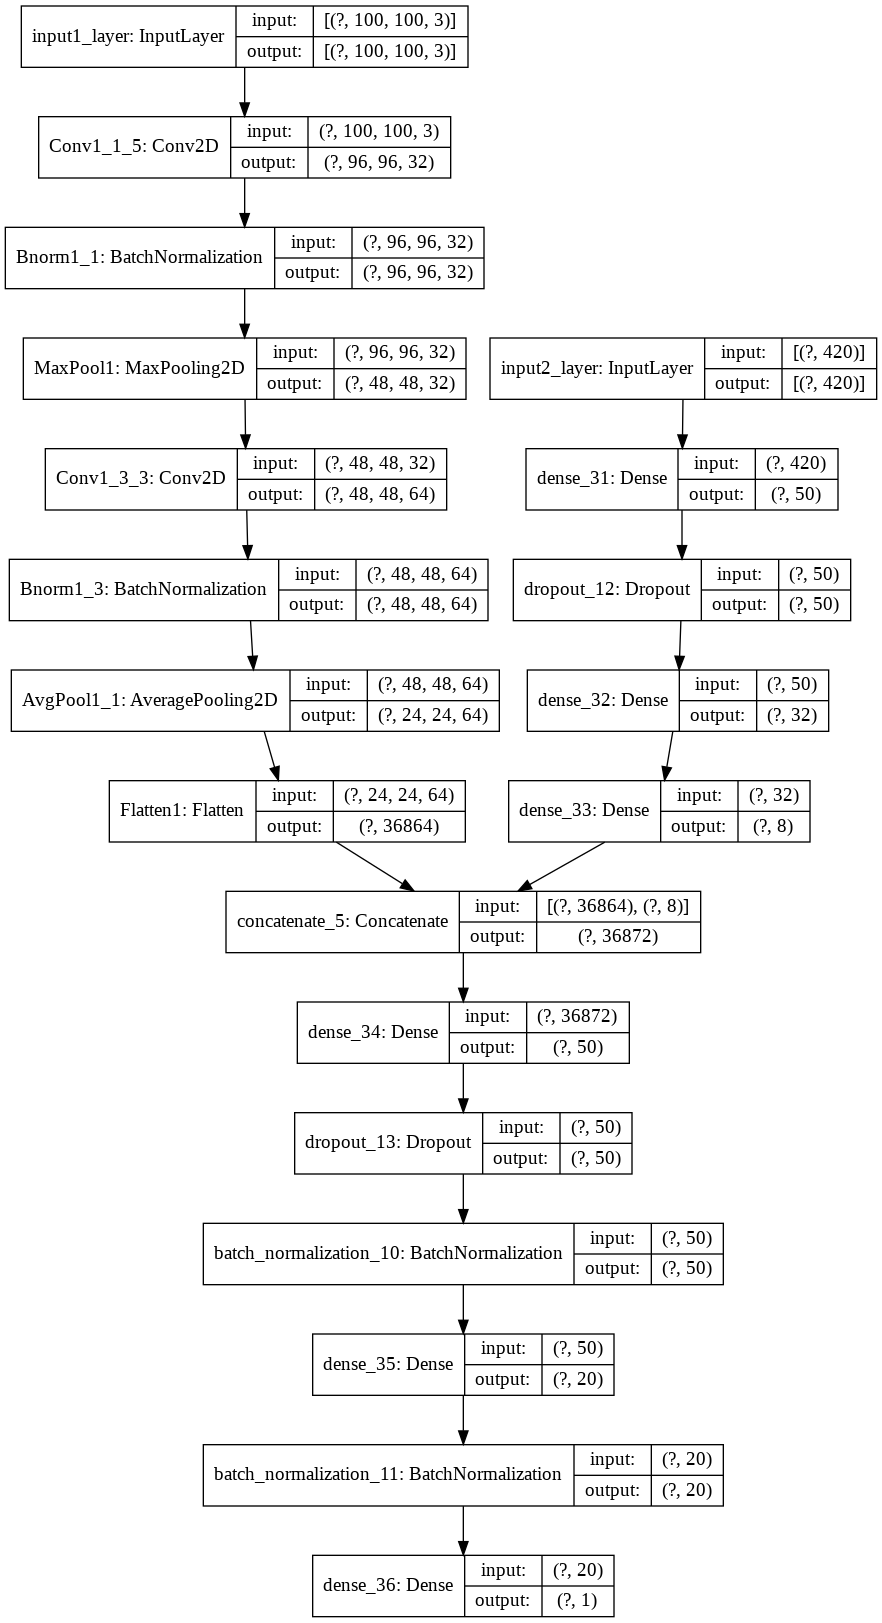

In [103]:
plot_model(model, show_shapes=True)

In [104]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer=adam, loss='mse')

In [106]:
history = model.fit(x = [X_imgtrain, X_train], y = y_train ,batch_size = 128 ,epochs= 5,validation_data=([X_imgtest, X_test],y_test),verbose=1,callbacks=[checkpointer])

Epoch 1/5
96/97 [============================>.] - ETA: 0s - loss: 601150783488.0000
Epoch 00001: val_loss did not improve from 0.00000
97/97 [==============================] - 4s 46ms/step - loss: 601421250560.0000 - val_loss: 776541700096.0000
Epoch 2/5
97/97 [==============================] - ETA: 0s - loss: 601413451776.0000
Epoch 00002: val_loss did not improve from 0.00000
97/97 [==============================] - 4s 44ms/step - loss: 601413451776.0000 - val_loss: 776549695488.0000
Epoch 3/5
97/97 [==============================] - ETA: 0s - loss: 601405259776.0000
Epoch 00003: val_loss did not improve from 0.00000
97/97 [==============================] - 4s 44ms/step - loss: 601405259776.0000 - val_loss: 776555659264.0000
Epoch 4/5
97/97 [==============================] - ETA: 0s - loss: 601395625984.0000
Epoch 00004: val_loss did not improve from 0.00000
97/97 [==============================] - 4s 45ms/step - loss: 601395625984.0000 - val_loss: 776514895872.0000
Epoch 5/5
97/97 

In [108]:
model.save_weights("model2_weights.h5")
model.save("model2.h5")

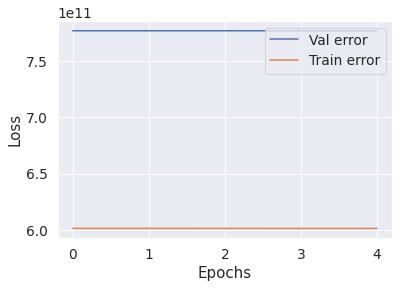

In [110]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

باز هم تغییری مشاهده نمی شود و به نظر می رسد تعداد لایه ها برای این داده ها زیاد است

##model3

In [111]:
input_model1 = Input((X_imgtrain.shape[1],X_imgtrain.shape[2],X_imgtrain.shape[3]),name = 'input1_layer')
input_model2 = Input((X_train.shape[1]),name = 'input2_layer')

#######################################################
#model1 CNN
model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Flatten(name = 'Flatten1')(model1)
#######################################################
#model2 nn
model2 = Dense(units = 40, activation = 'relu')(input_model2)
model2 = Dropout(rate = 0.2)(model2)
model2 = Dense(units = 8, activation = 'relu')(model2)
#######################################################
merged = Concatenate()([model1, model2])
# neural network 
merged = Dense(units = 40, activation = 'relu')(merged)
merged = Dropout(rate = 0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(units = 20, activation = 'relu')(merged)
merged = BatchNormalization()(merged)
output = Dense(units = 1, activation = 'linear')(merged)

model = Model(inputs= [input_model1,input_model2], outputs=[output])
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1_layer (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1_5 (Conv2D)              (None, 96, 96, 32)   2432        input1_layer[0][0]               
__________________________________________________________________________________________________
input2_layer (InputLayer)       [(None, 420)]        0                                            
__________________________________________________________________________________________________
Bnorm1_1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1_1_5[0][0]                  
______________________________________________________________________________________

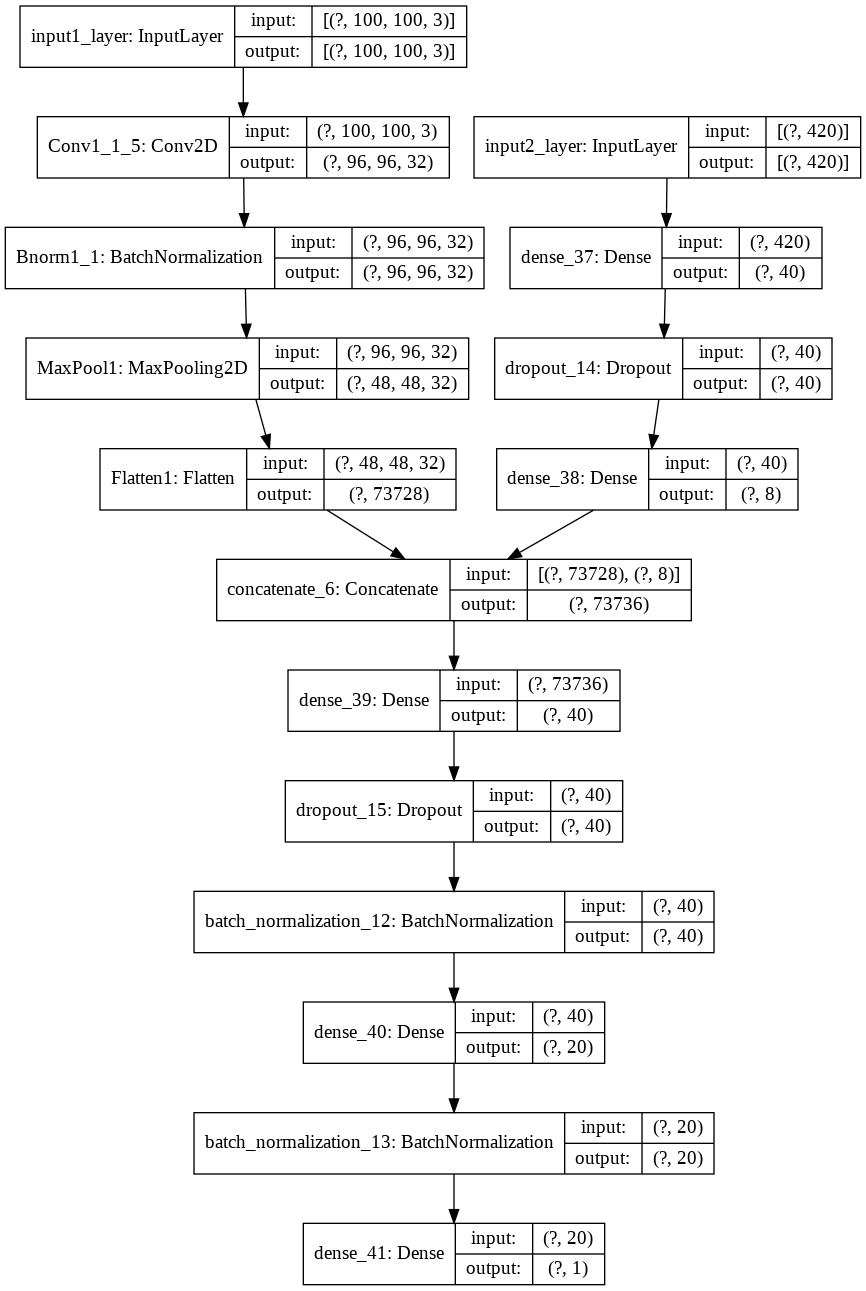

In [112]:
plot_model(model, show_shapes=True)

In [114]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer=adam, loss='mse')

In [115]:
history = model.fit(x = [X_imgtrain, X_train], y = y_train ,batch_size = 128 ,epochs= 5,validation_data=([X_imgtest, X_test],y_test),verbose=1,callbacks=[checkpointer])

Epoch 1/5
97/97 [==============================] - ETA: 0s - loss: 601424789504.0000
Epoch 00001: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 34ms/step - loss: 601424789504.0000 - val_loss: 776555855872.0000
Epoch 2/5
95/97 [============================>.] - ETA: 0s - loss: 601881313280.0000
Epoch 00002: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 32ms/step - loss: 601420660736.0000 - val_loss: 776586133504.0000
Epoch 3/5
95/97 [============================>.] - ETA: 0s - loss: 600851939328.0000
Epoch 00003: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 32ms/step - loss: 601412206592.0000 - val_loss: 776581152768.0000
Epoch 4/5
97/97 [==============================] - ETA: 0s - loss: 601402376192.0000
Epoch 00004: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 31ms/step - loss: 601402376192.0000 - val_loss: 776594391040.0000
Epoch 5/5
95/97 

In [116]:
model.save_weights("model3_weights.h5")
model.save("model3.h5")

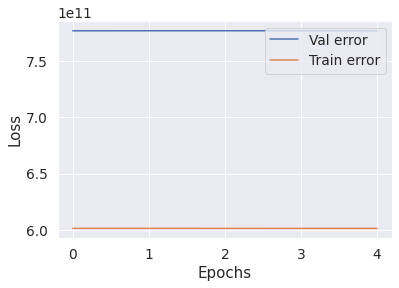

In [117]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

باز هم تغییری نکرد و خطای ما کاهش پیدا نمی کند.

##model4

In [118]:
input_model1 = Input((X_imgtrain.shape[1],X_imgtrain.shape[2],X_imgtrain.shape[3]),name = 'input1_layer')
input_model2 = Input((X_train.shape[1]),name = 'input2_layer')

#######################################################
#model1 CNN
model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_1_5')(input_model1)
model1 = BatchNormalization(name = 'Bnorm1_1')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Flatten(name = 'Flatten1')(model1)
#######################################################
#model2 nn
model2 = Dense(units = 40, activation = 'relu')(input_model2)
model2 = Dropout(rate = 0.2)(model2)
model2 = Dense(units = 8, activation = 'relu')(model2)
#######################################################
merged = Concatenate()([model1, model2])
# neural network 
merged = Dense(units = 20, activation = 'relu')(merged)
merged = Dropout(rate = 0.2)(merged)
merged = BatchNormalization()(merged)
output = Dense(units = 1, activation = 'linear')(merged)

model = Model(inputs= [input_model1,input_model2], outputs=[output])
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1_layer (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1_5 (Conv2D)              (None, 96, 96, 32)   2432        input1_layer[0][0]               
__________________________________________________________________________________________________
input2_layer (InputLayer)       [(None, 420)]        0                                            
__________________________________________________________________________________________________
Bnorm1_1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1_1_5[0][0]                  
______________________________________________________________________________________

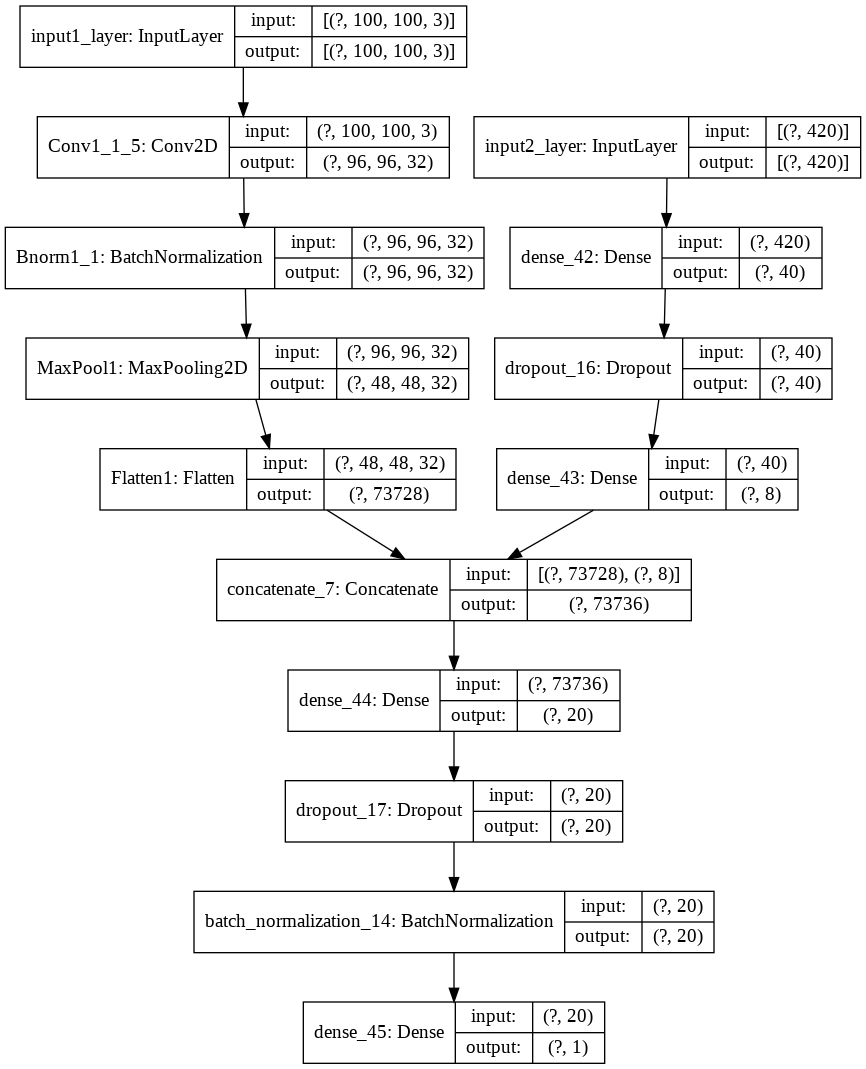

In [119]:
plot_model(model, show_shapes=True)

In [120]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer=adam, loss='mse')

In [121]:
history = model.fit(x = [X_imgtrain, X_train], y = y_train ,batch_size = 128 ,epochs= 5,validation_data=([X_imgtest, X_test],y_test),verbose=1,callbacks=[checkpointer])

Epoch 1/5
95/97 [============================>.] - ETA: 0s - loss: 600969248768.0000
Epoch 00001: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 33ms/step - loss: 601424658432.0000 - val_loss: 776562868224.0000
Epoch 2/5
96/97 [============================>.] - ETA: 0s - loss: 601159565312.0000
Epoch 00002: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 31ms/step - loss: 601420201984.0000 - val_loss: 776547205120.0000
Epoch 3/5
95/97 [============================>.] - ETA: 0s - loss: 603102838784.0000
Epoch 00003: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 31ms/step - loss: 601413320704.0000 - val_loss: 776542748672.0000
Epoch 4/5
95/97 [============================>.] - ETA: 0s - loss: 599824465920.0000
Epoch 00004: val_loss did not improve from 0.00000
97/97 [==============================] - 3s 31ms/step - loss: 601405718528.0000 - val_loss: 776533245952.0000
Epoch 5/5
95/97 

In [122]:
model.save_weights("model4_weights.h5")
model.save("model4.h5")

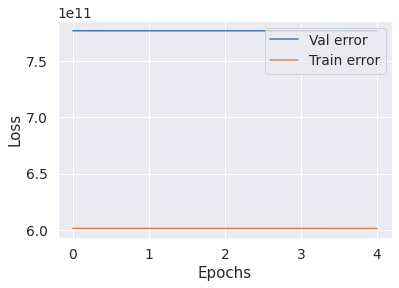

In [123]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

##Testing model with text data without image

In [124]:
input_model1 = Input((X_train.shape[1]),name = 'input1_layer')

#######################################################
#model1 nn
model1 = Dense(units = 40, activation = 'relu')(input_model1)
model1 = Dropout(rate = 0.2)(model1)
model1 = Dense(units = 30, activation = 'relu')(model1)
model1 = Dense(units = 20, activation = 'relu')(model1)
model1 = Dropout(rate = 0.2)(model1)
model1 = BatchNormalization()(model1)
output = Dense(units = 1, activation = 'linear')(model1)

model = Model(inputs=[input_model1], outputs=[output])
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1_layer (InputLayer)    [(None, 420)]             0         
_________________________________________________________________
dense_46 (Dense)             (None, 40)                16840     
_________________________________________________________________
dropout_18 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_48 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_19 (Dropout)         (None, 20)                0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 20)              

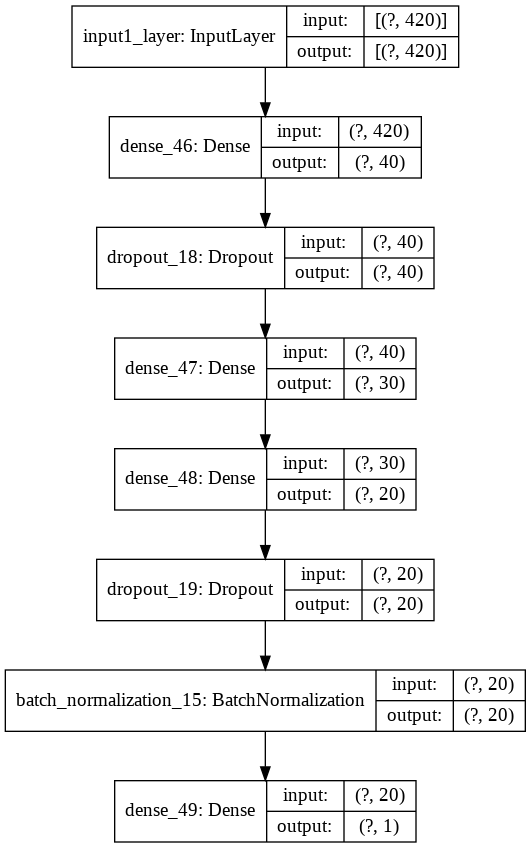

In [125]:
plot_model(model, show_shapes=True)

In [126]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer=adam, loss='mse')

In [127]:
history = model.fit(X_train,y_train ,batch_size = 128 ,epochs= 5,validation_data= (X_test,y_test),verbose=1,callbacks=[checkpointer])

Epoch 1/5
90/97 [==========================>...] - ETA: 0s - loss: 602007732224.0000
Epoch 00001: val_loss did not improve from 0.00000
97/97 [==============================] - 0s 4ms/step - loss: 601424658432.0000 - val_loss: 776556249088.0000
Epoch 2/5
88/97 [==========================>...] - ETA: 0s - loss: 605555589120.0000
Epoch 00002: val_loss did not improve from 0.00000
97/97 [==============================] - 0s 3ms/step - loss: 601420398592.0000 - val_loss: 776549498880.0000
Epoch 3/5
93/97 [===========================>..] - ETA: 0s - loss: 599814766592.0000
Epoch 00003: val_loss did not improve from 0.00000
97/97 [==============================] - 0s 3ms/step - loss: 601414762496.0000 - val_loss: 776542289920.0000
Epoch 4/5
90/97 [==========================>...] - ETA: 0s - loss: 604272001024.0000
Epoch 00004: val_loss did not improve from 0.00000
97/97 [==============================] - 0s 3ms/step - loss: 601407815680.0000 - val_loss: 776532459520.0000
Epoch 5/5
89/97 [===

In [128]:
model.save_weights("model_r1_weights.h5")
model.save("model_r1.h5")

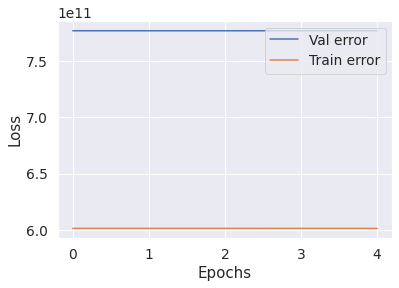

In [129]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

###Testing model with image data without text

In [131]:
input_model = Input((X_imgtrain.shape[1],X_imgtrain.shape[2],X_imgtrain.shape[3]),name = 'input_layer')

model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_5')(input_model)
model1 = BatchNormalization(name = 'Bnorm1')(model1)
model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv2_5')(model1)
model1 = BatchNormalization(name = 'Bnorm2')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv3_3')(model1)
model1 = BatchNormalization(name = 'Bnorm3')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv4_3')(model1)
model1 = BatchNormalization(name = 'Bnorm4')(model1)
model1 = AveragePooling2D((2, 2),name = 'AvgPool1')(model1)
model1 = Conv2D(128,(1,1), activation='relu' ,padding='valid',name = 'Conv5_1')(model1)
model1 = BatchNormalization(name = 'Bnorm5')(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
model1 = Dense(units = 32, activation = 'relu')(model1)
model1 = Dropout(rate = 0.2)(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 20, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 15, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
output = Dense(units = 1, activation = 'linear' , name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
Conv1_5 (Conv2D)             (None, 96, 96, 32)        2432      
_________________________________________________________________
Bnorm1 (BatchNormalization)  (None, 96, 96, 32)        128       
_________________________________________________________________
Conv2_5 (Conv2D)             (None, 96, 96, 32)        25632     
_________________________________________________________________
Bnorm2 (BatchNormalization)  (None, 96, 96, 32)        128       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 48, 48, 32)        0         
_________________________________________________________________
Conv3_3 (Conv2D)             (None, 48, 48, 64)      

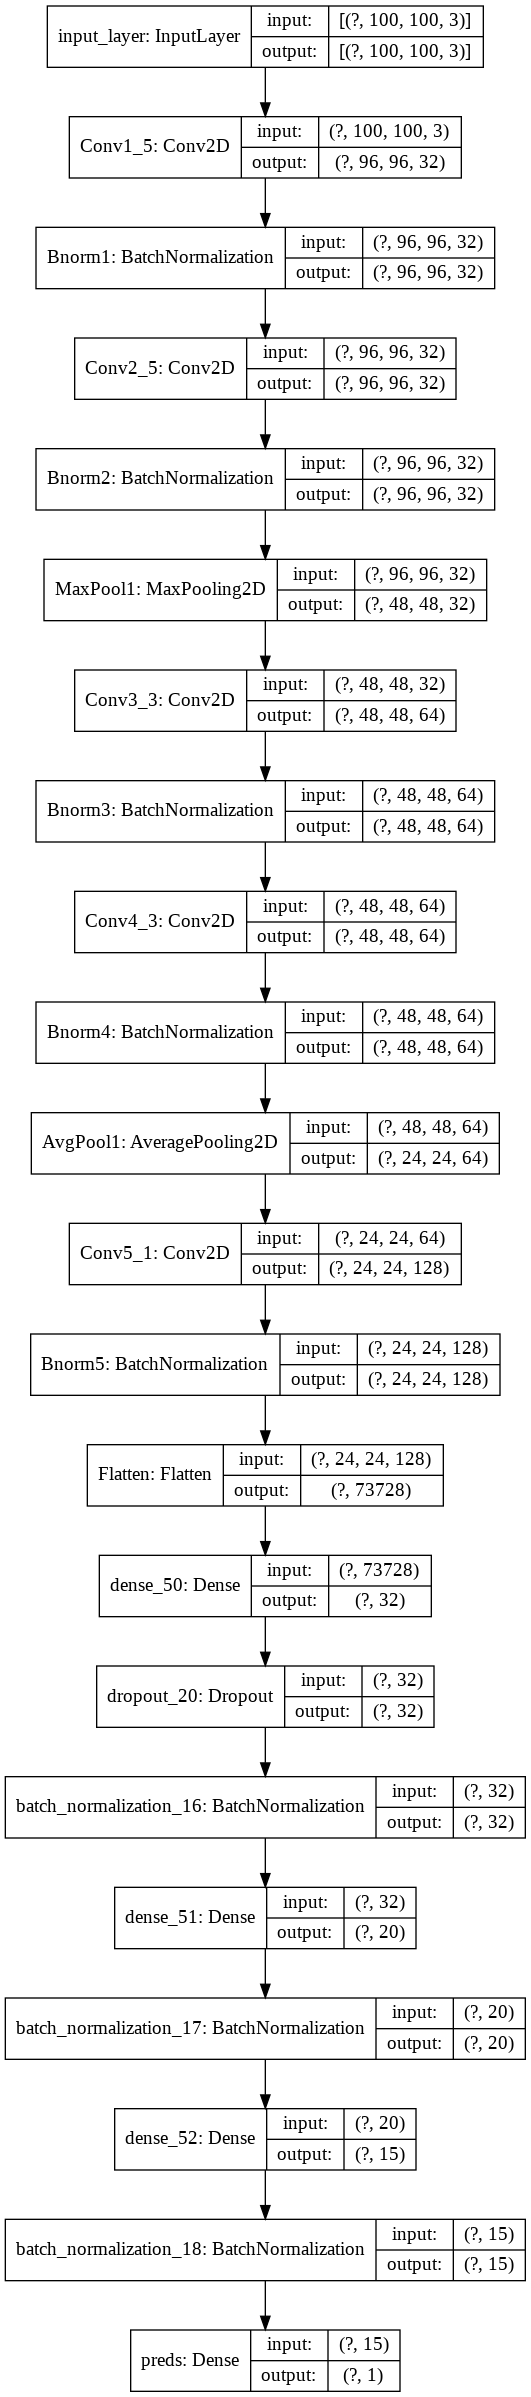

In [132]:
plot_model(model, show_shapes=True)

In [136]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss='mse')

In [138]:
history = model.fit(X_imgtrain,y_train, epochs= 5, validation_data= (X_imgtest,y_test), verbose=1, callbacks=[checkpointer])

Epoch 1/5
387/387 [==============================] - ETA: 0s - loss: nan
Epoch 00001: val_loss did not improve from 0.00000
387/387 [==============================] - 13s 33ms/step - loss: nan - val_loss: nan
Epoch 2/5
385/387 [============================>.] - ETA: 0s - loss: nan
Epoch 00002: val_loss did not improve from 0.00000
387/387 [==============================] - 13s 33ms/step - loss: nan - val_loss: nan
Epoch 3/5
387/387 [==============================] - ETA: 0s - loss: nan
Epoch 00003: val_loss did not improve from 0.00000
387/387 [==============================] - 13s 33ms/step - loss: nan - val_loss: nan
Epoch 4/5
387/387 [==============================] - ETA: 0s - loss: nan
Epoch 00004: val_loss did not improve from 0.00000
387/387 [==============================] - 13s 33ms/step - loss: nan - val_loss: nan
Epoch 5/5
387/387 [==============================] - ETA: 0s - loss: nan
Epoch 00005: val_loss did not improve from 0.00000
387/387 [==============================]

In [139]:
model.save_weights("model_rc1_weights.h5")
model.save("model1_rc1.h5")

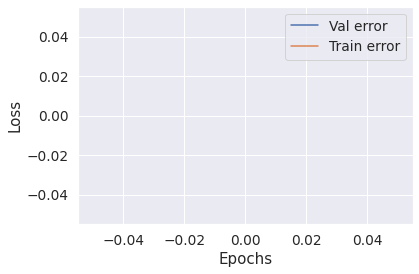

In [140]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error1.png')
plt.show()